# i. Perkenalan
Nama        : Nadia Nabilla Shafira

Batch       : HCK-009

Objectives  : Project ini bertujuan untuk mengetahui bagaimana pandangan user terhadap aplikasi Threads dengan melakukan sentiment analysis menggunakan beberapa model deep learning, yaitu RNN, LSTM, dan GRU.

Deployment  : https://huggingface.co/spaces/nadianshafira/Threads-Sentiment-Prediction

# ii. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering
from tensorflow.keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight

# Data Modeling
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, SimpleRNN, LSTM, GRU, Dropout, Dense, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Saving
import pickle
import json

# Others
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Nadia
[nltk_data]     Nabilla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nadia
[nltk_data]     Nabilla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# iii. Data Loading
> Data yang digunakan merupakan data review terhadap aplikasi Threads (by Instagram) yang diperoleh dari Kaggle (https://www.kaggle.com/datasets/saloni1712/threads-an-instagram-app-reviews/data).

In [2]:
df = pd.read_csv('P2G7_nadia_nabilla.csv')
df.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


Tabel di atas merupakan 5 data pertama dari data Threads Review.

In [3]:
# duplicate dataset
df1 = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


Berdasarkan informasi di atas, dapat dilihat bahwa dataset ini memiliki 32910 entries dengan 4 kolom. Output di atas juga menunjukkan bahwa tidak terdapat missing values pada dataset ini karena banyaknya rows pada masing-masing kolom adalah 32910.

## Data Cleaning

### Data Duplicate Detection & Handling

In [5]:
# data duplicate detection
df[df.duplicated()]

,source,review_description,rating,review_date
31351,App Store,We will get together tomorrow,5,2023-07-21 07:33:34


Berdasarkan output di atas, terdapat 1 data duplikat. Oleh karena itu, data duplikat tersebut akan dihapus.

In [6]:
# data duplicate handling
df.drop_duplicates(keep='first', inplace=True)
df.duplicated().sum()

0

In [7]:
df.shape

(32909, 4)

Setelah menghapus data duplikat, kini banyaknya entries adalah 32909.

### Rename Column Names

In [4]:
df = df.rename(columns={'review_description': 'review',         #mengubah nama kolom 'Height_(cm)' menjad 'Height'
                        'review_date': 'date'})        #mengubah nama kolom 'Weight_(kg)' menjadi 'Weight'
df.head(1)

,source,review,rating,date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24


### Rename Value of `rating`
> Dari skala 1 - 5, 1 dan 2 menunjukkan kesan yang kurang baik terhadap aplikasi Thread, 3 menunjukkan kesan 'biasa saja' atau netral, 4 dan 5 menunjukkan kesan yang baik terhadap aplikasi Thread. Oleh karena itu nilai rating akan diubah menjadi `-1`, `0`, dan `1`.

In [5]:
df['rating'].replace([1, 2, 3, 4, 5],
                       [-1, -1, 0, 1, 1], inplace=True)
df['rating'].unique()

array([-1,  0,  1], dtype=int64)

Rating `-1` menunjukkan kesan yang kurang baik, `0` menunjukkan kesan netral, dan `1` menunjukkan kesan yang baik.

In [6]:
class_labels = [-1, 0, 1]

# iv. Exploratory Data Analysis (EDA)

## Source

[Text(0, 0, '30270'), Text(0, 0, '2639')]

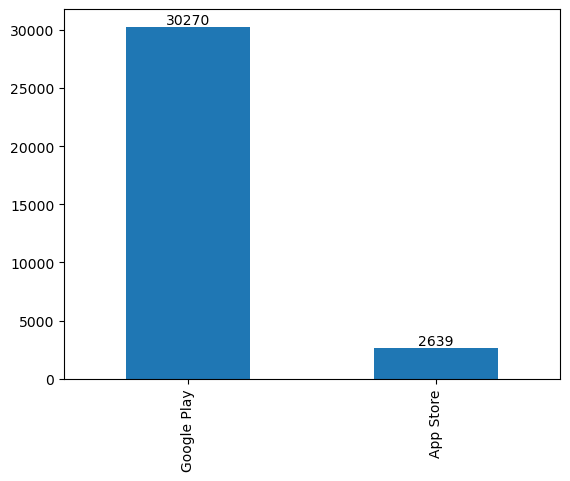

In [11]:
dfSource = df['source'].value_counts().plot(kind='bar')
dfSource.bar_label(dfSource.containers[0])

Berdasarkan bar chart di atas, dapat dilihat bahwa dari 32909 data, terdapat 30270 review yang diperoleh dari Google Play (91.9%), dan 2639 lainnya diperoleh dari App Store (8.1%).

## Review

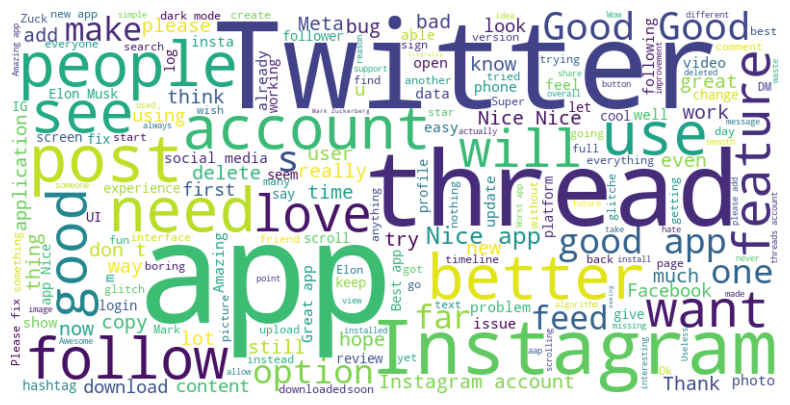

In [12]:
from wordcloud import WordCloud
text_data = df['review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

Berdasarkan wordcloud di atas, kata yang seringkali dituliskan oleh user dalam mengulas aplikasi Threads adalah `Twitter`, `app`, dan `Instagram`.

### Review Length

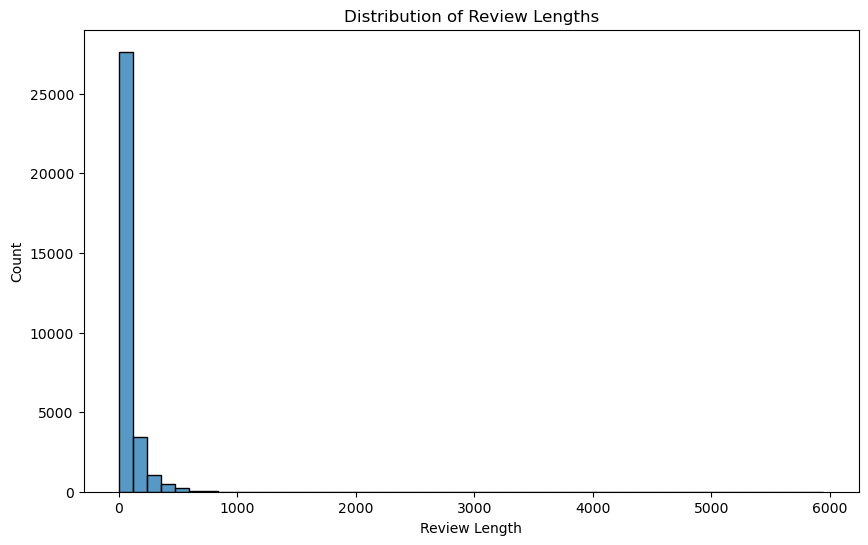

In [7]:
df['review_length'] = df['review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

Semua user menuliskan ulasannya tidak melebihi 1000 kata. dan Kebanyakan dari user menuliskannya sekitar 200 kata.

## Rating

[Text(0, 0, '11522'), Text(0, 0, '2585'), Text(0, 0, '18802')]

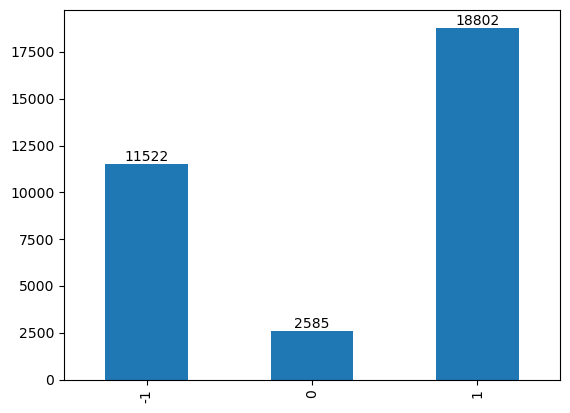

In [14]:
dfRating = df['rating'].value_counts().sort_index().plot(kind='bar')
dfRating.bar_label(dfRating.containers[0])

Berdasarkan bar chart di atas, dapat dilihat bahwa dari 32909 data, terdapat 11522 ulasan yang menunjukkan kesan negatif (35%), 2585 ulasan menunjukkan kesan netral (7.85%), dan 18802 lainnya diperoleh menunjukkan kesan positif (57.1%).

## Date

In [15]:
first_date = df['date'].min()
last_date = df['date'].max()

print("First date:", first_date)
print("Last date:", last_date)

First date: 2023-07-05 22:53:12
Last date: 2023-07-25 09:42:20


Berdasarkan informasi di atas, diketahui bahwa pada dataset ini, ulasan pertama kali diberikan pada 5 Juli 2023 pukul 22:53:12 dan terakhir kali diberikan pada 25 Juli 2023 pukul 09:42:20.

<Axes: >

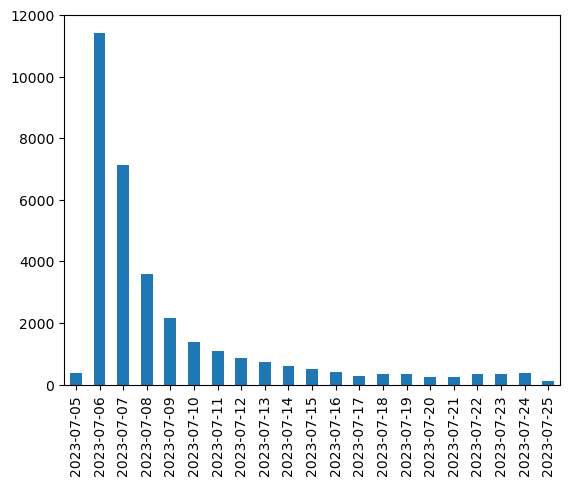

In [9]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date

dailyCounts = df['day'].value_counts().sort_index()
dailyCounts.plot(kind='bar')

Berdasarkan bar chart di atas, dapat dilihat bahwa ulasan paling banyak dibuat pada 6 Juli 2023.

# v. Feature Engineering

## Feature Selection
> Pada analisis ini, kolom yang dibutuhkan hanya kolom `review` dan `rating`. Oleh karena itu, selain kolom tersebut akan dihapus.

In [10]:
df = df.drop(['source', 'date', 'day', 'review_length'], axis=1)
df.head(3)

,review,rating
0,Meh. Not the greatest experience on a Chromebo...,-1
1,Pretty good for a first launch!! Its easy to u...,0
2,"For a brand new app, it's very well optimized....",0


## Text Preprocessing
> Kolom `review` berisi ulasan-ulasan yang dituliskan oleh user, sehingga terdapat karakter yang beragam. Oleh karena itu sebelum dilakukan pemodelan, ulasan-ulasan tersebut akan dibakukan dengan menghapus simbol, newline, whitespace, dan lain-lain.

In [11]:
# Define Stopwords
from nltk.corpus import stopwords
stpwds_en = list(set(stopwords.words()))

# Define Stemming
stemmer = PorterStemmer()

In [12]:
# Text Preprocessing Function

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_en]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [13]:
df['review_processed'] = df['review'].apply(lambda x: text_preprocessing(x))
df.head(3)

,review,rating,review_processed
0,Meh. Not the greatest experience on a Chromebo...,-1,meh greatest experi chromebook custom phone op...
1,Pretty good for a first launch!! Its easy to u...,0,pretti launch easi explanatori 'd algorithm gr...
2,"For a brand new app, it's very well optimized....",0,brand app 's optim 's miss featur app twitter ...


## Data Splitting

In [14]:
XTrain_val, XTest, yTrain_val, yTest = train_test_split(df.review_processed, df.rating, test_size=0.15, random_state=20, stratify=df.rating)
XTrain, XVal, yTrain, yVal = train_test_split(XTrain_val, yTrain_val, test_size=0.10, random_state=20, stratify=yTrain_val)

print('Train Size : ', XTrain.shape)
print('Val Size   : ', XVal.shape)
print('Test Size  : ', XTest.shape)

Train Size :  (25175,)
Val Size   :  (2798,)
Test Size  :  (4937,)


Berdasarkan output di atas, dapat dilihat bahwa banyaknya data train adalah 25174, banyaknya data validation adalah 2798, dan banyaknya data test adalah 4937.

## Target Encoding

In [16]:
yTrain_ohe = to_categorical(yTrain, 3)
yVal_ohe = to_categorical(yVal, 3)
yTest_ohe = to_categorical(yTest, 3)

## Text Vectorization
> Text Vectorization digunakan untuk mengonversi teks menjadi format numerik.

In [17]:
Vectorize = CountVectorizer()
XTrain_vec = Vectorize.fit_transform(XTrain)
XTest_vec = Vectorize.transform(XTest)

In [18]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in XTrain])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  9664
Maximum Sentence Length :  383 tokens


In [19]:
text_vectorization = TextVectorization(max_tokens=total_vocab, standardize="lower_and_strip_punctuation", split="whitespace",
                                       ngrams=None, output_mode="int", output_sequence_length=max_sen_len, input_shape=(1,))
text_vectorization.adapt(XTrain)

## Word Embedding

In [20]:
embedding = Embedding(input_dim=total_vocab, output_dim=128, embeddings_initializer="uniform", input_length=max_sen_len)

## Data Balancing
> Berdasarkan hasil analisis pada EDA, diketahui bahwa banyaknya data pada masing-masing label di kolom `rating` tidak seimbang, oleh karena itu perlu dilakukan data balancing.

In [21]:
class_weights = compute_class_weight('balanced', classes=np.unique(yTrain), y=yTrain)
class_weight_dict = dict(enumerate(class_weights))

# vi. Model Definition

## Simple RNN

In [32]:
seed = 20
embedding_dim = 128

rnn = Sequential()
rnn.add(text_vectorization)
rnn.add(embedding)
rnn.add(Bidirectional(SimpleRNN(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.35))
rnn.add(BatchNormalization())
rnn.add(Bidirectional(SimpleRNN(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.35))
rnn.add(BatchNormalization())
rnn.add(Dense(3, activation='softmax'))

lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
rnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics='accuracy')

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 383)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 383, 128)          1240320   
                                                                 
 bidirectional (Bidirection  (None, 383, 64)           10304     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 383, 64)           0         
                                                                 
 batch_normalization (Batch  (None, 383, 64)           256       
 Normalization)                                                  
                                                        

## LSTM

In [22]:
seed = 20
embedding_dim = 128

lstm = Sequential()
lstm.add(text_vectorization)
lstm.add(embedding)
lstm.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm.add(Dropout(0.35))
lstm.add(BatchNormalization())
lstm.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm.add(Dropout(0.35))
lstm.add(BatchNormalization())
lstm.add(Dense(3, activation='softmax'))

lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
lstm.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics='accuracy')

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 383)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 383, 128)          1236992   
                                                                 
 bidirectional (Bidirection  (None, 383, 64)           41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 383, 64)           0         
                                                                 
 batch_normalization (Batch  (None, 383, 64)           256       
 Normalization)                                                  
                                                        

## GRU

In [34]:
seed = 20
embedding_dim = 128

gru = Sequential()
gru.add(text_vectorization)
gru.add(embedding)
gru.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.35))
gru.add(BatchNormalization())
gru.add(Bidirectional(GRU(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.35))
gru.add(BatchNormalization())
gru.add(Dense(3, activation='softmax'))

lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
gru.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics='accuracy')

gru.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 383)               0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 383, 128)          1240320   
                                                                 
 bidirectional_4 (Bidirecti  (None, 383, 64)           31104     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 383, 64)           0         
                                                                 
 batch_normalization_4 (Bat  (None, 383, 64)           256       
 chNormalization)                                                
                                                      

# vii. Model Training

## SimpleRNN

In [37]:
callbacks_rnn=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
               ModelCheckpoint('rnn.keras', monitor='val_loss', save_best_only=True)]

rnn_hist = rnn.fit(XTrain, yTrain_ohe, epochs=50, batch_size=100, validation_data=(XVal, yVal_ohe), class_weight=class_weight_dict, callbacks=callbacks_rnn)

Epoch 1/50
252/252 [==============================] - 61s 241ms/step - loss: 0.9530 - accuracy: 0.7170 - val_loss: 1.0412 - val_accuracy: 0.6848
Epoch 2/50
252/252 [==============================] - 59s 236ms/step - loss: 0.7482 - accuracy: 0.7511 - val_loss: 1.1333 - val_accuracy: 0.6876
Epoch 3/50
252/252 [==============================] - 60s 236ms/step - loss: 0.6645 - accuracy: 0.7806 - val_loss: 0.8935 - val_accuracy: 0.7513
Epoch 4/50
252/252 [==============================] - 59s 234ms/step - loss: 0.6138 - accuracy: 0.8006 - val_loss: 1.0787 - val_accuracy: 0.7187
Epoch 5/50
252/252 [==============================] - 62s 247ms/step - loss: 0.5792 - accuracy: 0.8145 - val_loss: 1.1704 - val_accuracy: 0.7016
Epoch 6/50
252/252 [==============================] - 62s 245ms/step - loss: 0.5608 - accuracy: 0.8177 - val_loss: 1.0944 - val_accuracy: 0.7216


## LSTM

In [23]:
callbacks_lstm=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
               ModelCheckpoint('lstm', monitor='val_loss', save_best_only=True, save_format='tf')]
lstm_hist = lstm.fit(XTrain, yTrain_ohe, epochs=50, batch_size=100, validation_data=(XVal, yVal_ohe), class_weight=class_weight_dict, callbacks=callbacks_lstm)

Epoch 1/50

252/252 [==============================] - ETA: 0s - loss: 1.5836 - accuracy: 0.6521INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


252/252 [==============================] - 135s 515ms/step - loss: 1.5836 - accuracy: 0.6521 - val_loss: 0.9891 - val_accuracy: 0.5886
Epoch 2/50
252/252 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.7402INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


252/252 [==============================] - 127s 504ms/step - loss: 0.7714 - accuracy: 0.7402 - val_loss: 0.9651 - val_accuracy: 0.6973
Epoch 3/50
252/252 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7640INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


252/252 [==============================] - 239s 949ms/step - loss: 0.6663 - accuracy: 0.7640 - val_loss: 0.7130 - val_accuracy: 0.7566
Epoch 4/50
252/252 [==============================] - 242s 958ms/step - loss: 0.6067 - accuracy: 0.7790 - val_loss: 0.9178 - val_accuracy: 0.7209
Epoch 5/50
252/252 [==============================] - 267s 1s/step - loss: 0.5609 - accuracy: 0.7966 - val_loss: 0.8462 - val_accuracy: 0.7387
Epoch 6/50
252/252 [==============================] - 456s 2s/step - loss: 0.5286 - accuracy: 0.8056 - val_loss: 0.9193 - val_accuracy: 0.7527


## GRU

In [43]:
callbacks_gru=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
               ModelCheckpoint('gru.keras', monitor='val_loss', save_best_only=True)]
gru_hist = gru.fit(XTrain, yTrain_ohe, epochs=50, batch_size=250, validation_data=(XVal, yVal_ohe), class_weight=class_weight_dict, callbacks=callbacks_gru)

Epoch 1/50
101/101 [==============================] - 284s 3s/step - loss: 2.0964 - accuracy: 0.6033 - val_loss: 0.8594 - val_accuracy: 0.5790
Epoch 2/50
101/101 [==============================] - 304s 3s/step - loss: 1.0104 - accuracy: 0.7451 - val_loss: 0.8686 - val_accuracy: 0.6172
Epoch 3/50
101/101 [==============================] - 198s 2s/step - loss: 0.7568 - accuracy: 0.7700 - val_loss: 0.9753 - val_accuracy: 0.6408
Epoch 4/50
101/101 [==============================] - 203s 2s/step - loss: 0.6479 - accuracy: 0.7858 - val_loss: 0.8479 - val_accuracy: 0.7148
Epoch 5/50
101/101 [==============================] - 223s 2s/step - loss: 0.5987 - accuracy: 0.7961 - val_loss: 1.0191 - val_accuracy: 0.7059
Epoch 6/50
101/101 [==============================] - 207s 2s/step - loss: 0.5696 - accuracy: 0.8040 - val_loss: 1.0298 - val_accuracy: 0.7141
Epoch 7/50
101/101 [==============================] - 263s 3s/step - loss: 0.5426 - accuracy: 0.8110 - val_loss: 0.8297 - val_accuracy: 0.7502

# viii. Model Evaluation

## SimpleRNN

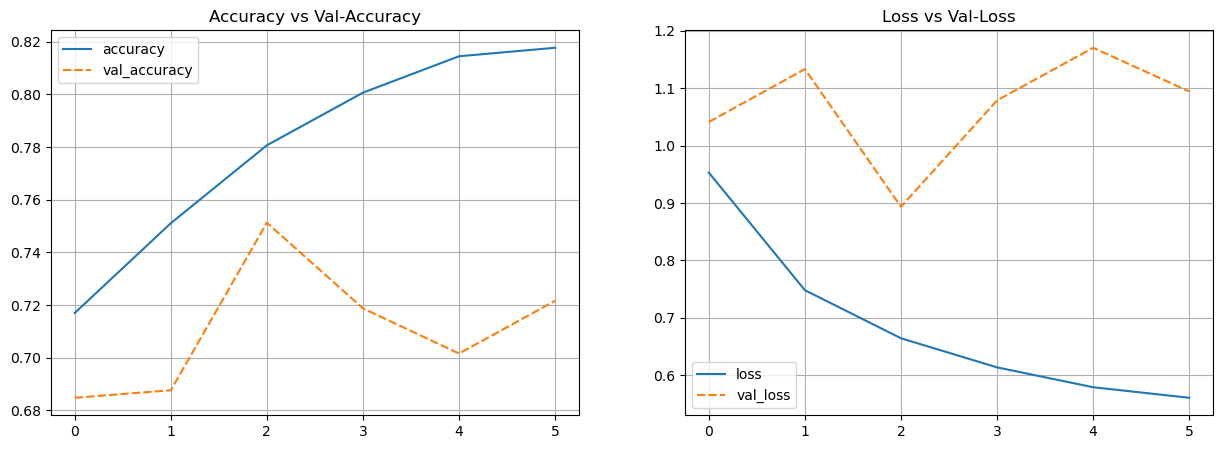

In [38]:
# Plot Training Results

rnn_hist_df = pd.DataFrame(rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=rnn_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=rnn_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [39]:
# Evaluate Test Set
result_rnn = rnn.evaluate(XTest, yTest_ohe)
result_rnn

155/155 [==============================] - 3s 20ms/step - loss: 0.8657 - accuracy: 0.7608


[0.8656638264656067, 0.7607858777046204]

Berdasarkan plot accuracy dan loss antara data train dan data validation, dapat disimpulkan bahwa model Simple RNN yang terbentuk overfit. Selain itu, diketahui juga nilai accuracy pada data test yaitu 76.08% dan loss pada data test yaitu 86.57%.

## LSTM

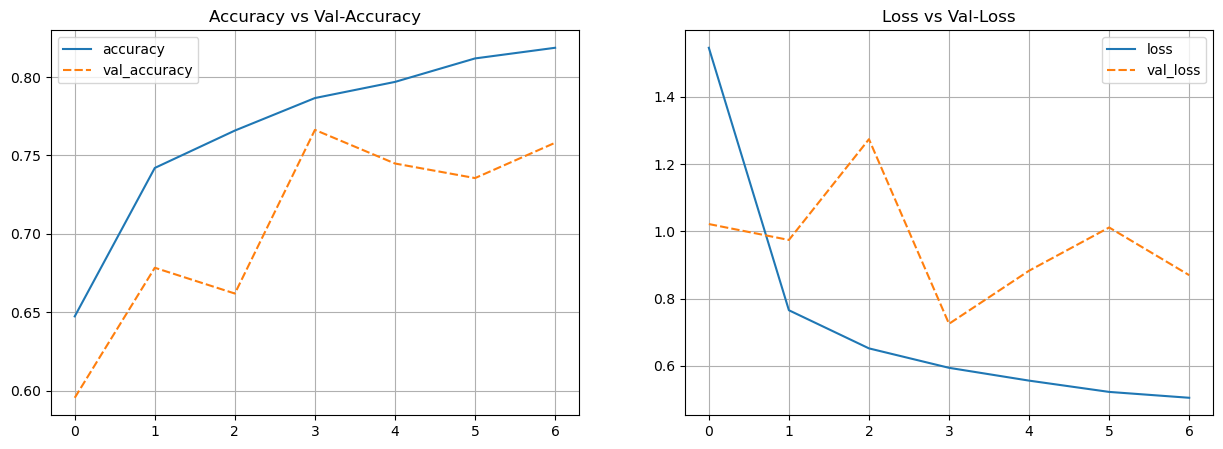

In [41]:
# Plot Training Results

lstm_hist_df = pd.DataFrame(lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=lstm_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=lstm_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [42]:
# Evaluate Test Set
result_lstm = lstm.evaluate(XTest, yTest_ohe)
result_lstm

155/155 [==============================] - 11s 72ms/step - loss: 0.6911 - accuracy: 0.7675


[0.6910786032676697, 0.767470121383667]

Berdasarkan plot accuracy dan loss antara data train dan data validation, dapat disimpulkan bahwa model LSTM yang terbentuk overfit, namun lebih baik jika dibandingkan dengan model Simple RNN. Selain itu, diketahui juga nilai accuracy pada data test yaitu 76.75% dan loss pada data test yaitu 69.11%.

## GRU

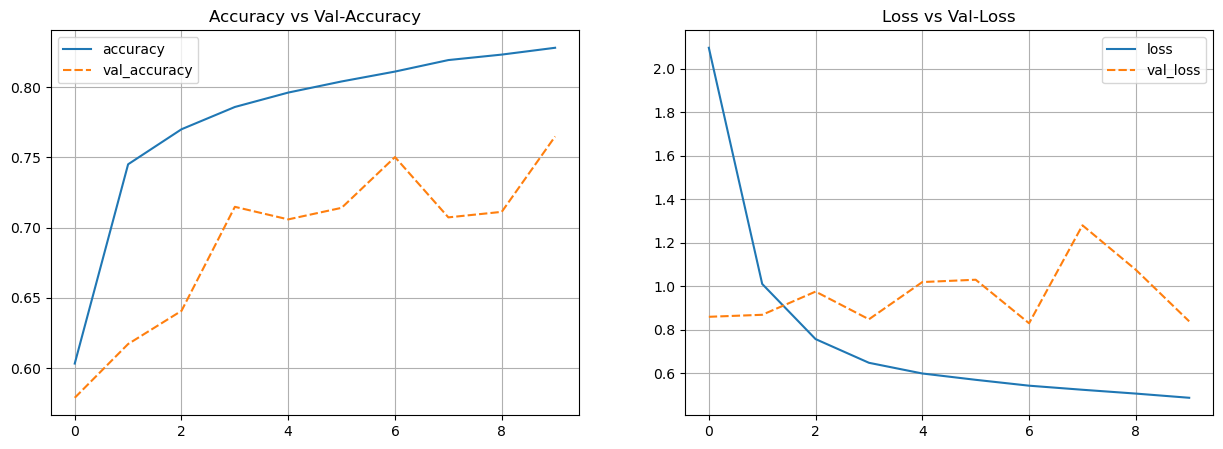

In [44]:
# Plot Training Results

gru_hist_df = pd.DataFrame(gru_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=gru_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=gru_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [45]:
# Evaluate Test Set
result_gru = gru.evaluate(XTest, yTest_ohe)
result_gru

155/155 [==============================] - 11s 69ms/step - loss: 0.8051 - accuracy: 0.7529


[0.8050589561462402, 0.7528863549232483]

Berdasarkan plot accuracy dan loss antara data train dan data validation, dapat disimpulkan bahwa model GRU yang terbentuk overfit. Selain itu, diketahui juga nilai accuracy pada data test yaitu 75.29% dan loss pada data test yaitu 80.51%.

# ix. Model Saving

Dengan menggunakan `ModelCheckpoint`, model akan otomatis tersimpan. Di mana saat training data menggunakan algoritma Simple RNN, model tersimpan dengan nama file `rnn.keras`, saat training dengan algoritma LSTM, model tersimpan dengan nama file `lstm.keras`, dan saat training dengan algoritma GRU, model tersimpan dengan nama file `gru.keras`.

In [32]:
with open('class_labels.pkl', 'wb') as file1:
    pickle.dump(class_labels, file1)

with open('stopwords.txt', 'w') as file2:
    json.dump(list(stpwds_en), file2)

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import tensorflow
print(tensorflow.__version__)


2.15.0


# x. Model Inference
> Model Inference akan dilakukan pada file P2G7_nadia_nabilla_inf.ipynb'

# xi. Kesimpulan

Setelah melakukan pemodelan untuk menganalisis sentimen user terhadap aplikasi threads, diperoleh model yang terbaik adalah LSTM dengan nilai accuracy tertinggi dibandingkan dengan model SimpleRNN dan GRU, dan juga LSTM memiliki nilai loss terkecil dibandingkan kedua model tersebut. Selain itu, saat memprediksi data test, diperoleh nilai accuracy sebesar 76.75%, artinya model dapat memprediksi sentimen atas ulasan seseorang terhadap aplikasi threads dengan benar sebesar 76.75%.